In [243]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [244]:
v_folder = 'DataSets/'

---

#### Lendo Dados Diários


In [245]:
# getting SP500 daily data

v_sp500_daily = pd.read_csv(v_folder + 'S&P500.csv', parse_dates=True)
v_sp500_daily['Date'] = pd.to_datetime(v_sp500_daily['Date'], infer_datetime_format=True)
v_sp500_daily.index = v_sp500_daily['Date'].values
v_sp500_daily['Volume'] = v_sp500_daily['Volume'].astype('float64')
v_sp500_daily.sort_index(inplace=True)
v_sp500_daily.dropna(thresh=4, axis=0, inplace=True)
v_sp500_daily.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5155 entries, 2000-01-03 to 2020-06-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5155 non-null   datetime64[ns]
 1   Open       5155 non-null   float64       
 2   High       5155 non-null   float64       
 3   Low        5155 non-null   float64       
 4   Close      5155 non-null   float64       
 5   Adj Close  5155 non-null   float64       
 6   Volume     5155 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 322.2 KB


---

#### Lendo Dados Semanais

Reamostragem do DataFrame diário (ex: _v_SP500_daily_ ) para periodicidade semanal, usando a sexta-feira como data de referência (index) da semana. Se o valor ('Close') referente à sexta-feira for faltante, devido a um feriado (dia não útil) por exemplo, então a imputação ocorre substituindo o valor de sexta-feira pelo último dia útil daquela semana, ex. quinta-feira. 

O campo 'Volume' da semana é um agregado dos volumes diários daquela semana.


In [246]:
v_sp500_week_start_date = v_sp500_daily.resample('W-FRI').first()['Date']
v_sp500_week_end_date = v_sp500_daily.resample('W-FRI').last()['Date']
v_sp500_num_of_weeks = min(len(v_sp500_week_start_date), len(v_sp500_week_end_date))

v_sp500_weekly_dict = {'Date': [], 'Close':[], 'Volume':[]}

for i in range(v_sp500_num_of_weeks):
    v_sp500_week = v_sp500_daily[v_sp500_week_start_date[i]:v_sp500_week_end_date[i]]
    if len(v_sp500_week) > 0:
        v_sp500_weekly_dict['Date'].append(v_sp500_week_end_date.index[i])
        v_sp500_weekly_dict['Close'].append(v_sp500_week['Close'][-1])
        v_sp500_weekly_dict['Volume'].append(v_sp500_week['Volume'].sum())
        
v_sp500_weekly = pd.DataFrame.from_dict(v_sp500_weekly_dict)
v_sp500_weekly.index = pd.to_datetime(v_sp500_weekly['Date'].values)
v_sp500_weekly.drop(['Date'], axis=1, inplace=True)
v_sp500_weekly['Volume'] = v_sp500_weekly['Volume'].astype('float64')
v_sp500_weekly.info()
v_sp500_weekly.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1070 entries, 2000-01-07 to 2020-07-03
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1070 non-null   float64
 1   Volume  1070 non-null   float64
dtypes: float64(2)
memory usage: 25.1 KB


,Close,Volume
2000-01-07,1441.469971,5.343800e+09
2000-01-14,1465.150024,5.169700e+09
2000-01-21,1441.359985,4.455000e+09
2000-01-28,1360.160034,5.532100e+09
2000-02-04,1424.369995,5.205000e+09


In [247]:
v_sp500_weekly.tail()

,Close,Volume
2020-06-05,3193.929932,3.089592e+10
2020-06-12,3041.310059,3.424198e+10
2020-06-19,3097.739990,2.887610e+10
2020-06-26,3009.050049,2.787095e+10
2020-07-03,3053.239990,4.462770e+09


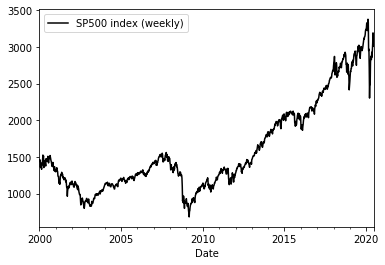

In [248]:
v_sp500_weekly['Close'].plot(style='k', label='SP500 index (weekly)')
#v_nasdaq_weekly['Close'].plot(style='r', label='NASDAQ index (weekly)')
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

---

## Feature Engineering on weekly data:


In [249]:
def get_weekly_features_for_exchanges(exchange_name_list:list = [], exchange_dataframe_list:list = [], frequency:str = 'weekly_'):
    
    nr_exchanges = len(exchange_dataframe_list)
    
    # function output: a list of DataFrames containing the calculated features for each exchange
    exchange_features_dataframe_list = []
    
    for i in range(nr_exchanges):
    
        # get a copy of the current exchange dataframe
        v_data = exchange_dataframe_list[i].copy()
        # get the current exchange name
        current_exchange_name = exchange_name_list[i] + '_'
        # daily DataFrame that will hold the generated features
        v_data_features = pd.DataFrame(index = v_data.index)

        # ----------------------------------------------------------------------
        # closing price trend (from closing price time series) 

        # closing price
        df_field = current_exchange_name + frequency + 'close'
        v_data_features[df_field] = v_data.loc[:,'Close'].values 

        
        # ----------------------------------------------------------------------
        # Volatility, Skewness and Kurtosis (from log weekly return distribution)

        # compute the logarithmic returns using the closing price 
        v_logRet = np.log(v_data['Close'] / v_data['Close'].shift(1))
        df_field = current_exchange_name + frequency + 'log_returns'
        v_data_features[df_field] = v_logRet 

        # compute 5-week annualized volatility
        period = 5
        v_feature = v_logRet.rolling(window=period).std() * np.sqrt(52)
        df_field = current_exchange_name + frequency + 'volatility_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 13-week annualized volatility
        period = 13
        v_feature = v_logRet.rolling(window=period).std() * np.sqrt(52)
        df_field = current_exchange_name + frequency +  'volatility_' + str(period) 
        v_data_features[df_field] = v_feature 
        
        # compute 26-week annualized volatility
        period = 26
        v_feature = v_logRet.rolling(window=period).std() * np.sqrt(52)
        df_field = current_exchange_name + frequency +  'volatility_' + str(period) 
        v_data_features[df_field] = v_feature 
        
        # compute 52-week annualized volatility
        period = 52
        v_feature = v_logRet.rolling(window=period).std() * np.sqrt(52)
        df_field = current_exchange_name + frequency +  'volatility_' + str(period) 
        v_data_features[df_field] = v_feature 
        
        # compute 13-week skewness 
        period = 13
        v_feature = v_logRet.rolling(window=period).skew()
        df_field = current_exchange_name + frequency + 'skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 26-week skewness 
        period = 26
        v_feature = v_logRet.rolling(window=period).skew()
        df_field = current_exchange_name + frequency + 'skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 52-week skewness 
        period = 52
        v_feature = v_logRet.rolling(window=period).skew()
        df_field = current_exchange_name + frequency + 'skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 13-week kurtosis
        period = 13
        v_feature = v_logRet.rolling(window=period).kurt()
        df_field = current_exchange_name + frequency + 'kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 26-week kurtosis
        period = 26
        v_feature = v_logRet.rolling(window=period).kurt()
        df_field = current_exchange_name + frequency + 'kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 52-week kurtosis
        period = 52
        v_feature = v_logRet.rolling(window=period).kurt()
        df_field = current_exchange_name + frequency + 'kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # ----------------------------------------------------------------------
        # 52 Weeks High and Low

        # 52 Weeks High
        df_field = current_exchange_name + frequency + '52_Week_High'
        v_data_features[df_field] = np.log(v_data['Close'] / v_data['Close'].rolling(52).max())
        
        # 52 Weeks Low
        df_field = current_exchange_name + frequency + '52_Week_Low'
        v_data_features[df_field] = np.log(v_data['Close'] / v_data['Close'].rolling(52).min())
        
        # stores each exchange DataFrame of features within a list 
        exchange_features_dataframe_list.append(v_data_features)
    
    return exchange_features_dataframe_list

---

## Feature Engineering on Weekly Data:

In [250]:
# list of Exchange names
exc_name_list = ['sp500']

# list of corresponding DataFrames with weekly frequency: v_sp500_weekly, v_nasdaq_weekly, etc. 
exc_dataframe_list = []
exc_dataframe_list.append(v_sp500_weekly)

temp_list = get_weekly_features_for_exchanges(exchange_name_list = exc_name_list , exchange_dataframe_list = exc_dataframe_list, frequency = 'weekly_')


In [251]:
# DataFrame of weekly features for SP500
v_sp500_weekly_features = temp_list[0] 
v_sp500_weekly_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1070 entries, 2000-01-07 to 2020-07-03
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp500_weekly_close          1070 non-null   float64
 1   sp500_weekly_log_returns    1069 non-null   float64
 2   sp500_weekly_volatility_5   1065 non-null   float64
 3   sp500_weekly_volatility_13  1057 non-null   float64
 4   sp500_weekly_volatility_26  1044 non-null   float64
 5   sp500_weekly_volatility_52  1018 non-null   float64
 6   sp500_weekly_skewness_13    1057 non-null   float64
 7   sp500_weekly_skewness_26    1044 non-null   float64
 8   sp500_weekly_skewness_52    1018 non-null   float64
 9   sp500_weekly_kurtosis_13    1057 non-null   float64
 10  sp500_weekly_kurtosis_26    1044 non-null   float64
 11  sp500_weekly_kurtosis_52    1018 non-null   float64
 12  sp500_weekly_52_Week_High   1019 non-null   float64
 13  sp500_weekly_52

---

## Feature Analysis with respect to Labels using Box-Plots:

the idea here is to analyze which features help to discriminate the samples belonging to the "BEAR" and "BULL" classes (or labels). 

we also check the capabilities of the features to discriminate samples that lie on the transition region between the regimes:

- "T-BEAR": samples that lie on the transition from "BULL" to "BEAR"
- "T-BULL": samples that lie on the transition from "BEAR" to "BULL"



In [252]:
df_target = pd.read_csv(v_folder + 'sp500_target_regimes_withTransitions', parse_dates=True)
df_target.index = pd.to_datetime(df_target['date'].values, infer_datetime_format=True)
df_target.sort_index(inplace=True)
df_target.drop(['date'], axis=1, inplace=True)
df_target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1070 entries, 2000-01-07 to 2020-07-03
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   close          1070 non-null   float64
 1   regime         1069 non-null   object 
 2   log_returns    1069 non-null   float64
 3   is_transition  1069 non-null   object 
dtypes: float64(2), object(2)
memory usage: 41.8+ KB


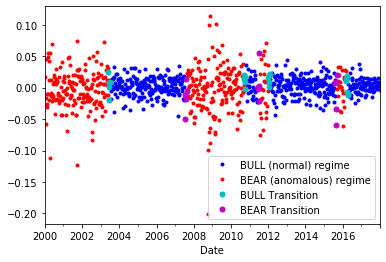

In [253]:
# ploting SP500 label samples along with log-returns

start_date = '20000101'
end_date = '20150101'

# bolean expressions for filtering transition samples
is_trans = df_target['is_transition']
is_bear = df_target['regime'] == 'BEAR'
is_bull = df_target['regime'] == 'BULL'

# samples with BULL labels that dont lie on the transition  
v_sp500_bull = df_target['log_returns'].copy()
v_sp500_bull[is_bear | is_trans] = None

# samples with BEAR labels that dont lie on the transition  
v_sp500_bear = df_target['log_returns'].copy()
v_sp500_bear[is_bull | is_trans] = None

# samples with BULL labels that lie on the transition  
v_sp500_bull_trans = df_target['log_returns'].copy()
v_sp500_bull_trans[is_bear] = None
v_sp500_bull_trans[is_bull & ~is_trans.astype(bool)] = None

# samples with BEAR labels that lie on the transition  
v_sp500_bear_trans = df_target['log_returns'].copy()
v_sp500_bear_trans[is_bull] = None
v_sp500_bear_trans[is_bear & ~is_trans.astype(bool)] = None

v_sp500_bull = v_sp500_bull[start_date:end_date] 
v_sp500_bear = v_sp500_bear[start_date:end_date] 
v_sp500_bull_trans = v_sp500_bull_trans[start_date:end_date] 
v_sp500_bear_trans = v_sp500_bear_trans[start_date:end_date] 

v_sp500_bull.plot(style='b.', label='BULL (normal) regime')
v_sp500_bear.plot(style='r.', label='BEAR (anomalous) regime')
v_sp500_bull_trans.plot(style='c.', markersize=10, label='BULL Transition')
v_sp500_bear_trans.plot(style='m.', markersize=10, label='BEAR Transition')
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

Feature Name :  sp500_weekly_close


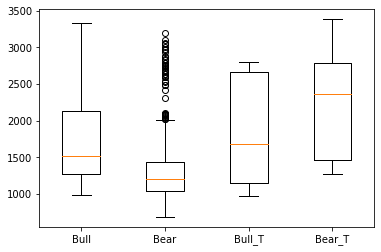

Feature Name :  sp500_weekly_log_returns


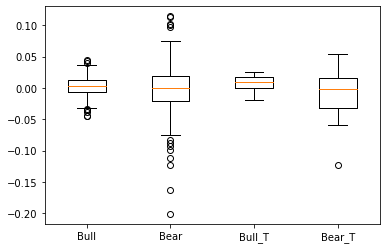

Feature Name :  sp500_weekly_volatility_5


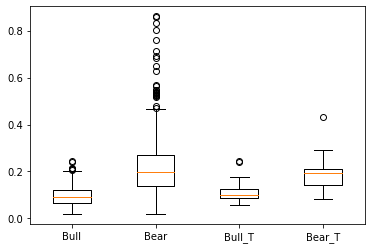

Feature Name :  sp500_weekly_volatility_13


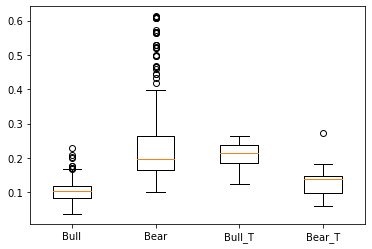

Feature Name :  sp500_weekly_volatility_26


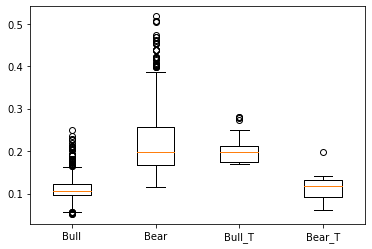

Feature Name :  sp500_weekly_volatility_52


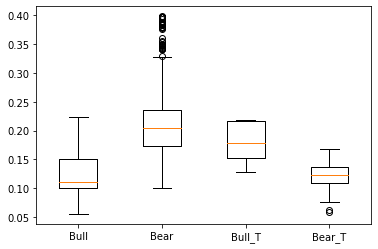

Feature Name :  sp500_weekly_skewness_13


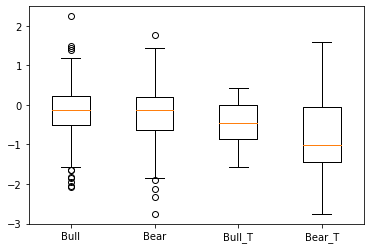

Feature Name :  sp500_weekly_skewness_26


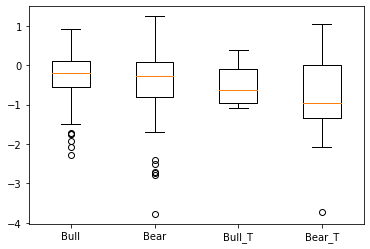

Feature Name :  sp500_weekly_skewness_52


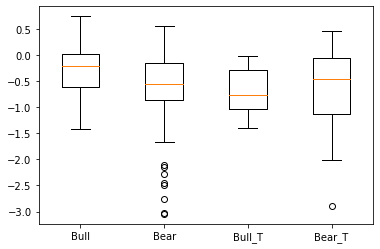

Feature Name :  sp500_weekly_kurtosis_13


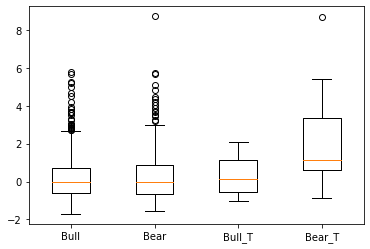

Feature Name :  sp500_weekly_kurtosis_26


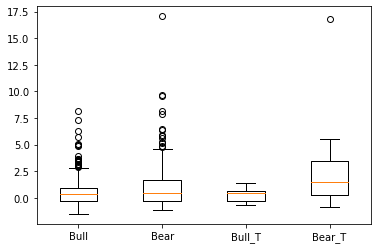

Feature Name :  sp500_weekly_kurtosis_52


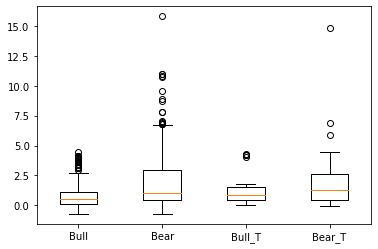

Feature Name :  sp500_weekly_52_Week_High


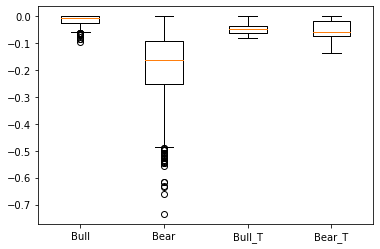

Feature Name :  sp500_weekly_52_Week_Low


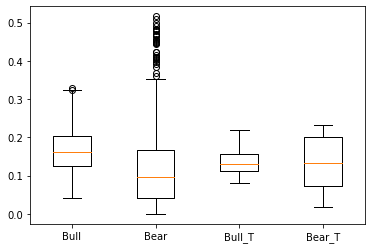

In [259]:
# iterates on the Feature Engineering DataFrame e plots the boxplots for each feature grouped by the class label column

bear_dates = df_target[is_bear & ~is_trans.astype(bool)].index
#print(bear_dates)
bull_dates = df_target[is_bull & ~is_trans.astype(bool)].index
bear_transition_dates = df_target[is_trans & is_bear].index
#print(bear_transition_dates)
bull_transition_dates = df_target[is_trans & is_bull].index

# Iterate over the sequence of column names
for column in v_sp500_weekly_features:
    
    print('Feature Name : ', column)
    column_series = v_sp500_weekly_features[column]
    
    # get data grouped by the class label regime
    bull_samples = column_series.loc[bull_dates].values
    bear_samples = column_series.loc[bear_dates].values
    bull_trans_samples = column_series.loc[bull_transition_dates].values
    bear_trans_samples = column_series.loc[bear_transition_dates].values
    
    # remove the NaNs from the data before plot boxplot
    bull_samples_filtered = bull_samples[~np.isnan(bull_samples)]
    bear_samples_filtered = bear_samples[~np.isnan(bear_samples)]
    bull_trans_samples_filtered = bull_trans_samples[~np.isnan(bull_trans_samples)]
    bear_trans_samples_filtered = bear_trans_samples[~np.isnan(bear_trans_samples)]

    data_list = [bull_samples_filtered, bear_samples_filtered, bull_trans_samples_filtered, bear_trans_samples_filtered]
    #print(data_list[1])
    
    # multiple box plots on one Axes
    fig, ax = plt.subplots()
    ax.boxplot(data_list)
    ax.set_xticklabels(['Bull', 'Bear', 'Bull_T', 'Bear_T'])
    plt.show()
    